# Objectron

One of mobile real-time 3D object detection tools for common objects is called MediaPipe Objectron, which uses a machine learning (ML) model trained on the Objectron dataset. It can identify objects in 2D images and estimate their poses.

## Setup

In [2]:
from PIL import Image
import numpy
from numpy import asarray
import mediapipe as mp

import cv2
import numpy as np
import matplotlib.pyplot as plt

## Pipeline

To estimate the 3D bounding box of an object from a single RGB image, two machine learning (ML) pipelines are used: one is a two-stage pipeline, and the other is a single-stage pipeline. With comparable or higher precision, the two-stage pipeline is 3x faster than the one-stage pipeline. Whereas the two stage pipeline excels at detecting a single dominating item, the single stage pipeline excels at detecting many objects.

### Two Stage Pipeline
The 2D crop of the object is located in the first stage using an object detector. The second stage calculates the 3D bounding box using the image crop. In order to avoid running the object detector every frame, it additionally computes the 2D crop of the object for the following frame.

### Single-stage Pipeline
The encoder-decoder architecture of the model backbone is based on MobileNetv2. We take a multi-task learning strategy, combining detection and regression to jointly estimate the shape of an item. Depending on the ground truth annotation that is provided, such as segmentation, the shape task predicts the object's shape signals. If there is no shape annotation in the training data, this is not necessary. We use the annotated bounding boxes for the detection job and fit a Gaussian to the box, with the center at the centroid of the box and standard deviations proportional to the box size. The objective of detection is to forecast this distribution, with its peak denoting the location of the core of object. The eight bounding box vertices' 2D projections are estimated by the regression task. We use a well-known posture estimation approach to generate the final 3D coordinates for the bounding box (EPnP). Without knowing the size of the object beforehand, it may recover the 3D bounding box.

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_objectron = mp.solutions.objectron

# For static images:
IMAGE_FILES = []
with mp_objectron.Objectron(static_image_mode=True,
                            max_num_objects=5,
                            min_detection_confidence=0.5,
                            model_name='Chair') as objectron:
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    # Convert the BGR image to RGB and process it with MediaPipe Objectron.
    results = objectron.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Draw box landmarks.
    if not results.detected_objects:
      print(f'No box landmarks detected on {file}')
      continue
    print(f'Box landmarks of {file}:')
    annotated_image = image.copy()
    for detected_object in results.detected_objects:
      mp_drawing.draw_landmarks(
          annotated_image, detected_object.landmarks_2d, mp_objectron.BOX_CONNECTIONS)
      mp_drawing.draw_axis(annotated_image, detected_object.rotation,
                           detected_object.translation)
      cv2.imwrite('/tmp/annotated_image' + str(idx) + '.png', annotated_image)
    

# For webcam input:
cap = cv2.VideoCapture(0)
with mp_objectron.Objectron(static_image_mode=False,
                            max_num_objects=5,
                            min_detection_confidence=0.5,
                            min_tracking_confidence=0.99,
                            model_name='Cup') as objectron:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = objectron.process(image)

    # Draw the box landmarks on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.detected_objects:
        for detected_object in results.detected_objects:
            mp_drawing.draw_landmarks(
              image, detected_object.landmarks_2d, mp_objectron.BOX_CONNECTIONS)
            mp_drawing.draw_axis(image, detected_object.rotation,
                                 detected_object.translation)
    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Objectron', cv2.flip(image, 1))
    if cv2.waitKey(5) & 0xFF == 27:
      break
cap.release()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


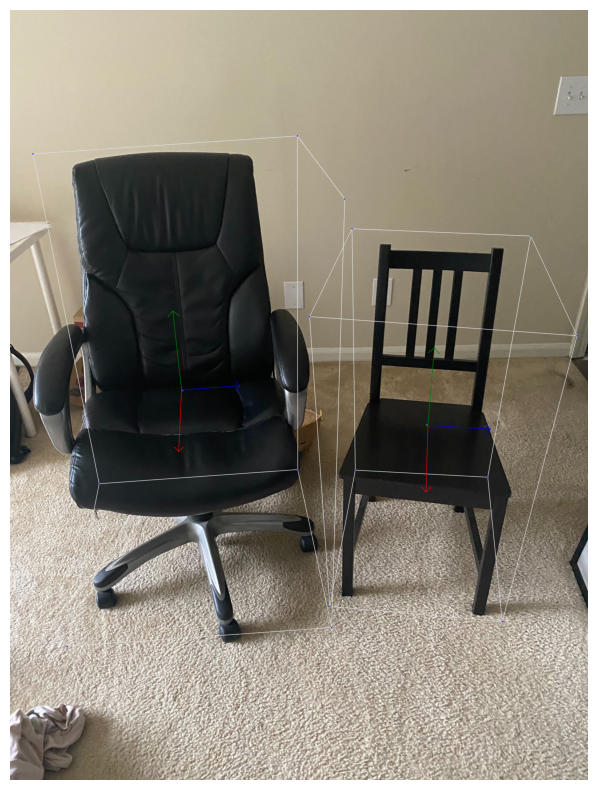

In [2]:
img= Image.open('data/chair_two.jpg')
np_img = numpy.array(img)
mp_objectron = mp.solutions.objectron
mp_drawing = mp.solutions.drawing_utils

objectron = mp_objectron.Objectron(
    static_image_mode=True,
    max_num_objects=5,
    min_detection_confidence=0.2,
    model_name='Chair')

results = objectron.process(np_img)

if not results.detected_objects:
    print(f'No object detected.')

# Copy image so as not to draw on the original one
annotated_image = np_img.copy()
for detected_object in results.detected_objects:
    # Draw landmarks
    mp_drawing.draw_landmarks(annotated_image, 
                              detected_object.landmarks_2d, 
                              mp_objectron.BOX_CONNECTIONS)

    # Draw axis based on rotation and translation
    mp_drawing.draw_axis(annotated_image, 
                         detected_object.rotation, 
                         detected_object.translation)
  
# Plot result
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(annotated_image)
ax.axis('off')
plt.show()